In [11]:
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [12]:
import tfdirectional as tfdir
import tensorflow as tf

In [15]:
rotation = tf.placeholder(shape=(32,3,3), dtype=tf.float32)
concentration = tf.placeholder(shape=(32,3), dtype=tf.float32)

vec = tf.placeholder(shape=(32,3), dtype=tf.float32)

distr = tfdir.distributions.Bingham(rotation, concentration)

In [16]:
l = distr.log_prob(vec)

In [17]:
sess = tf.Session()

In [25]:
sess.run(l, feed_dict={rotation: randn(32,3,3),
                       concentration: randn(32,3),
                        vec: randn(32,3)})

array([  8.5618725 , -26.120878  ,   0.6794003 ,  -3.051964  ,
        -0.8037257 , -10.457333  ,  -8.269031  ,  -1.304846  ,
        -0.8194772 ,   9.508719  ,   4.3450913 ,  -0.1206964 ,
       -12.6161585 ,  -5.7165213 ,   0.19898307,   7.848876  ,
        -2.0945745 , -22.993834  ,  30.68884   , -28.438684  ,
        -7.047803  ,   1.0278432 ,  34.038536  ,  -3.0537033 ,
       -10.687134  ,   2.5273366 , -22.480417  ,  -1.2847064 ,
         9.965685  ,  -3.176401  ,   8.179589  , -13.678457  ],
      dtype=float32)

In [64]:
# sample polar coordimnates
theta = np.linspace(0, np.pi, 128)
phi = np.linspace(0, 2*np.pi, 128)
phi, theta = np.meshgrid(phi, theta)

# cartesian coordinates of the unit sphere
r = 1.0
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

v = np.stack([x,y,z],axis=-1)

In [65]:
batch_size=128*128
vec = tf.placeholder(shape=(batch_size,3), dtype=tf.float32)
distr = tfdir.distributions.Bingham(tf.eye(3, batch_shape=(batch_size,)),
                                    2*tf.eye(3, batch_shape=(batch_size,))[...,0])
          
l = distr.log_prob(vec)
pdf = exp(sess.run(l, feed_dict={vec: v.reshape((-1,3))}))

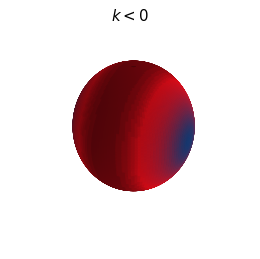

In [66]:
# set up a figure
fig = plt.figure(figsize=(15.0,4.5))

# calculate the pdf for given k<0
fcolors = pdf.reshape((128,128))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_title(r'$k<0$', fontsize=15)
ax.plot_surface(x, y, z,  rstride=1, cstride=1,
                facecolors=cm.gist_stern(fcolors))
ax.set_axis_off()